In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pyxdf  # load file.xdf
import seaborn as sns

In [4]:
# load data

# Montage file
MONTAGE = 'DATA/montage_perfect.csv'

# EEG data file
GROUPS = ['DATA/Group_Realistic_Arm/', 'DATA/Group_Realistic_Arm_Tactile/', 'DATA/Group_Unrealistic_Arm/', 'DATA/Group_Unrealistic_Arm_Tactile/']
SUBJECTS = ['sub-S01_', 'sub-S02_', 'sub-S03_', 'sub-S04_', 'sub-S05_', 'sub-S06_', 'sub-S07_', 'sub-S08_', 'sub-S09_', 'sub-S10_']
EXPERIMENTS = ['eegBaselineEC.xdf', 'eegBaselineEO.xdf', 'MIpre.xdf', 'PO.xdf',  'MIpost.xdf']

# Select EEG data file
data_S09_MI = GROUPS[0] + SUBJECTS[8] + EXPERIMENTS[2]
data_S09_PO = GROUPS[0] + SUBJECTS[8] + EXPERIMENTS[3]


# Experimental variables
bandpass_cutoff_low = 1.5
bandpass_cutoff_high = 40
time_offset = -1
duration = 5

In [10]:
# Auxiliary functions
def get_data_of_stream_type(streams, stream_type):
    """
    Return the index of the stream with the given type.
    param: streams: list of streams
    param: stream_type: type of the stream (e.g. 'EEG', 'TargetID')
    return: data of the stream with the given type
    """
    if stream_type == 'EEG': name = 'eegoSports 000'
    
    elif stream_type == 'TargetID': name = 'MI trial marke'
    else :
        raise NameError(
            f"given type '{type}' is not an argument. Accepted types are 'EEG' and 'TargetID'"
        )
    for i in range(len(streams)):
        if streams[i]['info']['name'][0][:14] == name:
            return i

    raise NameError(
         f"given type '{stream_type}' cannot be found in any of the streams"
    )

def get_raw_data(streams, montage, bad_channels = ['M1', 'M2', 'Trigger'], scalings = 0.00013):
    """
    Return the raw data of the stream with the given type.
    param: streams: list of streams
    param: montage: montage file
    param: bad_channels: list of bad channels (to be excluded)
    param: scalings: scaling factor for the data
    return: raw data of the stream with the given type
    """
    stream_type = 'EEG'
    stream_index = get_data_of_stream_type(streams, stream_type)
    stream = streams[stream_index]['time_series'].T * 1e-6 # convert from uV to V (mne uses V)
    sfreq = float(streams[stream_index]['info']['nominal_srate'][0])
    ch_types = ['eeg'] * 64 + ['misc'] + ['bio']
    montage_label = pd.read_csv(montage)
    channel_label = montage_label['ch_name'].tolist()
    channel_label.append('Trigger')
    channel_label.append('GSR')
    info_passive = mne.create_info(channel_label, sfreq, ch_types)
    raw_passive = mne.io.RawArray(stream, info_passive) 
    print("\n  \n  Raw data information \n \n ", raw_passive.info)
    raw_passive.info['bads'].extend(bad_channels)
    raw_passive.plot(scalings=scalings); 
    return raw_passive

def filter_data(raw, low_cutoff, high_cutoff, filter_type = 'both'):
    """
    Return the filtered data of the stream with the given type.
    param: raw: raw data of the stream with the given type
    param: low_cutoff: low cutoff frequency
    param: high_cutoff: high cutoff frequency
    param: filter_type: type of filter (e.g. 'bandpass', 'CAR', 'both')
    return: filtered data of the stream with the given type
    """
    if filter_type == 'bandpass' or filter_type == 'both':
        raw = raw.filter(low_cutoff, high_cutoff)
    elif filter_type == 'CAR' or filter_type == 'both':
        raw, data_ref = mne.set_eeg_reference(raw, ref_channels = 'average', copy = True)
    else :
        raise NameError(f"given type '{filter_type}' is not an argument. Accepted types are 'bandpass', 'CAR' and 'both'")
    return raw

def get_epochs(streams, raw, time_offset, duration):
    """
    Return the epochs of the stream with the given type.
    param: streams: list of streams
    param: raw: raw data of the stream with the given type
    param: time_offset: time offset
    param: duration: duration
    return: epochs of the stream with the given type
    """
    TargetID = get_data_of_stream_type(streams, 'TargetID')
    EEG = get_data_of_stream_type(streams, 'EEG')
    t_origin = streams[EEG]['time_stamps'][0]
    time_stamps = streams[TargetID]['time_stamps'] - t_origin  # signal begins at 0s
    target_nb = np.array(streams[TargetID]['time_series']).squeeze()  # array with target IDs

    annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)  
    raw_annot = raw.set_annotations(annots)
    events, event_ids = mne.events_from_annotations(raw_annot)
    epochs = mne.Epochs(raw, events, event_ids, tmin=time_offset, tmax=duration, baseline=(time_offset,0), reject=dict(eeg=400e-6), preload=True)  # bad channels won't appear on graph
    epochs_resampled = epochs.resample(200)
    epochs_resampled['2'].plot(events=events, event_id=event_ids); 
    epochs_resampled['5'].plot(events=events, event_id=event_ids); 
    epochs_resampled['8'].plot(events=events, event_id=event_ids); 
    return epochs_resampled

def extract_synchronisation_level(eeg_data, frequency_band):
    if frequency_band == 'alpha':
        fmin = 8
        fmax = 13
    elif frequency_band == 'beta':
        fmin = 13
        fmax = 30
    eeg_data_filtered = eeg_data.filter(l_freq=fmin, h_freq=fmax)
    return eeg_data_filtered

def epochs_to_dataframe(epochs_resampled):
    """
    Return the dataframe of the epochs.
    param: epochs_resampled: epochs of the stream with the given type
    return: dataframe of the epochs
    """
    epochs_alpha = extract_synchronisation_level(epochs_resampled, 'alpha')
    epochs_beta = extract_synchronisation_level(epochs_resampled, 'beta')
    df_alpha = epochs_alpha.pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2', 
                                    'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 
                                    'Cpz', 'Cp4', 'Cp5', 'Cp6']).to_data_frame()
    df_beta = epochs_beta.pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2',
                                    'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 
                                    'Cpz', 'Cp4', 'Cp5', 'Cp6']).to_data_frame()

    df = pd.concat([df_alpha, df_beta], keys=['alpha', 'beta'])
    df.reset_index(level = 0, inplace=True)
    df.rename(columns={'level_0': 'freq_band'}, inplace=True)
    return df

def calculate_power(df):
    """
    Calculate the power of each channel in a dataframe
    :param df: dataframe with EEG data
    :return: a dataframe with the power of each channel
    """
    df_power = df.copy()
    for channel in df_power.columns[4:]:
        df_power[channel] = df_power[channel].apply(lambda x: x ** 2)
    return df_power

def calculate_mean_power_over_all_trials(df):
    """
    Calculate the mean power of each channel over all trials for each condition
    :param df: dataframe with EEG data
    :return: a dataframe with the mean power of each channel across conditions and trials
    """
    df_mean_power = pd.DataFrame()
    for channel in df.columns[4:]:
        mean_power = df.groupby(['freq_band', 'condition', 'time'])[channel].mean()
        df_mean_power[channel] = mean_power
    df_mean_power.reset_index(inplace=True)
    return df_mean_power

def get_baseline(df):
    """
    Get the baseline of a dataframe
    :param df: dataframe with EEG data
    :return: a dataframe with the baseline of each channel
    """
    df_baseline = df[df['time'] < 0].groupby(['freq_band', 'condition']).mean()
    df_baseline.drop(columns=['time'], inplace=True)
    df_baseline.reset_index(inplace=True)
    df_baseline = df_baseline.loc[df_baseline.index.repeat(20)]
    return df_baseline

def extract_time_windows(df, fs, win_len, step):
    """
    Extract time windows from a dataframe with EEG data
    :param df: dataframe with EEG data
    :param fs: sampling frequency
    :param win_len: length of the time windows in seconds
    :param step: step between two consecutive windows in seconds
    :return: a list of dataframes, each dataframe is a time window
    """
    win_size = int(win_len * fs)
    step_size = int(step * fs)
    df_win = pd.DataFrame()
    idx = 200
    win_num = 0

    while idx < df.shape[0] - win_size:
        win = df.iloc[idx:idx + win_size, :]
        win.insert(loc=3, column='window', value=win_num)
        # win['window'] = pd.Series([win_num for x in range(len(win))], index=win.index)
        df_win = pd.concat([df_win, win], ignore_index=True)
        idx += step_size
        win_num += 1

    return df_win

def get_windows(df_mean_power):
    """
    Get the time windows of a dataframe
    :param df_mean_power: dataframe with EEG data
    :return: a list of dataframes, each dataframe is a time window
    """
    df_windows = pd.DataFrame()
    for freq_band in df_mean_power['freq_band'].unique():
        for condition in df_mean_power['condition'].unique():
            trial = df_mean_power[(df_mean_power['freq_band'] == freq_band) & (df_mean_power['condition'] == condition)]
            trial_windows = extract_time_windows(df=trial, fs=200, win_len=1.000, step=0.200)
            df_windows = pd.concat([df_windows, trial_windows], ignore_index=True)
    return df_windows

def average_windows(df):
    """
    Average the power of each channel over all time windows
    :param df: dataframe with EEG data
    :return: a dataframe with the average power of each channel
    """
    df_avg = pd.DataFrame()
    for channel in df.columns[5:]:
        avg = df.groupby(['freq_band', 'condition', 'window'])[channel].mean()
        df_avg[channel] = avg
    df_avg.reset_index(inplace=True)
    return df_avg

def get_percentage_from_baseline(df, df_baseline):
    """
    Get the percentage of each channel from baseline
    :param df: dataframe with EEG data
    :param df_baseline: dataframe with the baseline of each channel
    :return: a dataframe with the percentage of each channel from baseline
    """
    df_percentage = df.copy()
    for channel in df_percentage.columns[3:]:
        df_percentage[channel] = (df_percentage[channel] - df_baseline[channel].values)*100 / df_baseline[channel].values
    return df_percentage

def plot_per(df_percentage):
    """
    Plot the percentage of each channel from baseline
    :param df_percentage: dataframe with the percentage of each channel from baseline
    :return: None
    """
    for channel in df_percentage.columns[3:]:
        for freq in df_percentage['freq_band'].unique():
            for cond in df_percentage['condition'].unique():
                df = df_percentage[(df_percentage['freq_band'] == freq) & (df_percentage['condition'] == cond)]
                sns.lineplot(data=df, x='window', y=channel)
                plt.title(f'{channel} {freq} {cond}')
                plt.show()


In [7]:
streams, header = pyxdf.load_xdf(data_S09_MI)

Stream 4: Calculated effective sampling rate 15622.5270 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 5274.2149 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=66, n_times=1274056
    Range : 0 ... 1274055 =      0.000 ...   637.028 secs
Ready.

  
  Raw data information 
 
  <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc, 1 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 2000.0 Hz
>
Using matplotlib as 2D backend.


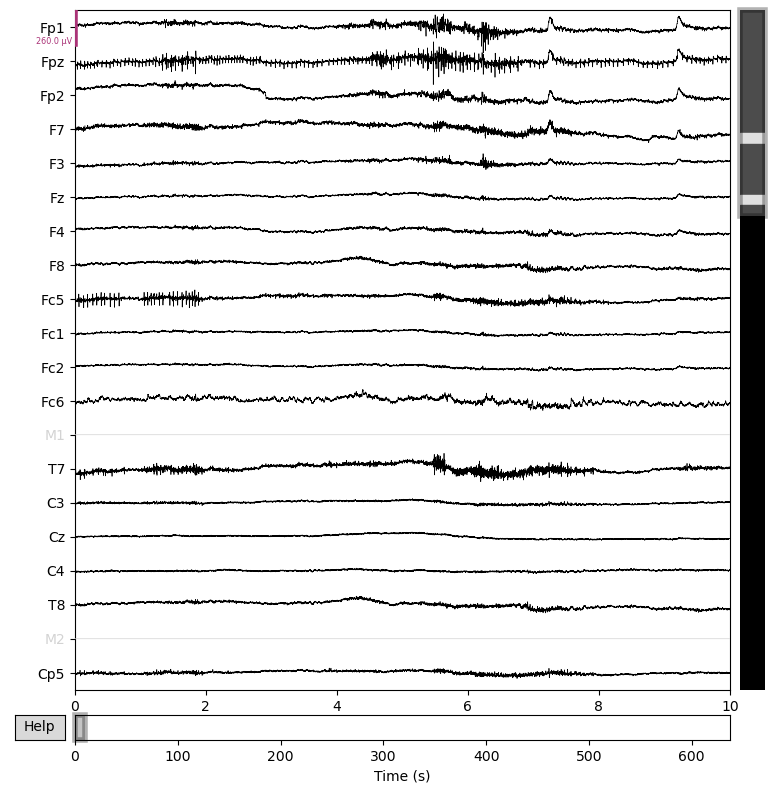

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 4401 samples (2.200 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.4s finished


In [8]:
raw_data = get_raw_data(streams, MONTAGE, bad_channels = ['M1', 'M2'], scalings = 0.00013)
filtered_data = filter_data(raw_data, bandpass_cutoff_low, bandpass_cutoff_high, filter_type = 'both')

In [11]:
epochs_resampled = get_epochs(streams, filtered_data, time_offset, duration)

Used Annotations descriptions: ['Left', 'Right', 'Third']


RuntimeError: Event time samples were not unique. Consider setting the `event_repeated` parameter."

In [ ]:
epochs_resampled = get_epochs(streams, filtered_data, time_offset, duration)
df = epochs_to_dataframe(epochs_resampled)

df_power = calculate_power(df)

df_mean_power = calculate_mean_power_over_all_trials(df_power)

df_baseline = get_baseline(df_mean_power)

df_windows = get_windows(df_mean_power)

df_avg = average_windows(df_windows)

df_percentage = get_percentage_from_baseline(df=df_avg, df_baseline=df_baseline)

plot_per(df_percentage)